In [ ]:
#Copy Training dataset from Google drive to session storage

zip_path_test = '/content/drive/My Drive/Python/SUBMISSION FOLDER/nsfw_dataset.zip'
!cp '{zip_path_test}' .
!unzip -q nsfw_dataset.zip
!rm nsfw_dataset.zip

In [ ]:
#Copy Validation dataset from Google drive to session storage

zip_path_test = '/content/drive/My Drive/Python/SUBMISSION FOLDER/nsfw_validation.zip'
!cp '{zip_path_test}' .
!unzip -q nsfw_validation.zip
!rm nsfw_validation.zip

In [ ]:
#Copy Testing dataset from Google drive to session storage

zip_path_test = '/content/drive/My Drive/Python/SUBMISSION FOLDER/nsfw_testing.zip'
!cp '{zip_path_test}' .
!unzip -q nsfw_testing.zip
!rm nsfw_testing.zip

In [ ]:
#Set path for each folder of respective datasets below

train_root = '/content/nsfw_dataset'
train_root_nsfw = '/content/nsfw_dataset/nsfw'
train_root_safe = '/content/nsfw_dataset/safe'

eval_root = '/content/nsfw_validation'
eval_root_nsfw = '/content/nsfw_validation/nsfw'
eval_root_safe = '/content/nsfw_validation/safe'

test_root = '/content/nsfw_testing'
test_root_nsfw = '/content/nsfw_testing/nsfw'
test_root_safe = '/content/nsfw_testing/safe'

In [ ]:
import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

from keras.callbacks import History 

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using Tensorflow version  2.3.0


In [ ]:
#Declaring variables needed by the model 

IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

In [ ]:
#Importing VGG16 pre-trained model

from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',    
                 include_top=False,     
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
#Configuring the locked model

def build_model_xfer():
    from tensorflow.keras.optimizers import Adam
    
    
    
    model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#Building the locked model

model_xfer = build_model_xfer()
print(model_xfer.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [ ]:
#Train data rescaling and Augmentation to improve training process

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
#Rescaling the output from the data gennerators 

eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
#Train data generator 

train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 40002 images belonging to 2 classes.


In [ ]:
#Validation data generator 

eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 8058 images belonging to 2 classes.


In [ ]:
#Test data generator 

test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 7928 images belonging to 2 classes.


In [ ]:
#Defining steps for each dataset

train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(1250, 251, 247)

In [ ]:
#Training the Model and saving models with improved validation score

from keras.callbacks import ModelCheckpoint

filepath="weights-improvement-VGG16-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=eval_generator,
    validation_steps=val_steps,
    callbacks=callbacks_list) 

In [ ]:
#Plotting Training Loss vs Validation Loss of Locked Model

loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

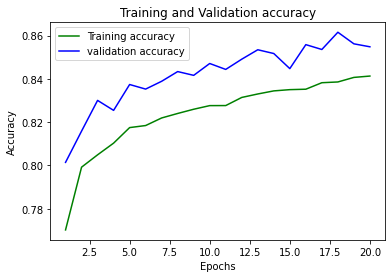

In [ ]:
#Plotting Training Accuracy Vs Validation Accuracy Of Locked Model

loss_train = hist.history['accuracy']
loss_val = hist.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Evaluating locked model on Trainiing, Validation and Test datasets

loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Training data  -> loss: 0.402, acc: 0.817
Cross-val data -> loss: 0.400, acc: 0.814
Testing data   -> loss: 0.410, acc: 0.806


In [ ]:
#Defining VGG16 model again for Unlocked Model

vgg_base2 = VGG16(weights='imagenet',    
                 include_top=False,     
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base2.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#Unlocking previous Layers of VGG16 

trainable = False

for layer in vgg_base2.layers:
    if layer.name == 'block5_conv2':
        trainable = True
   
    layer.trainable = trainable
    
print(vgg_base2.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
#Configuring structure of Unlocked Model

def build_model_xfer2():
    
    
    
    
    model = tf.keras.models.Sequential([
        
        vgg_base2,
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#Building Unlocked Model

model_xfer2 = build_model_xfer2()
print(model_xfer2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [ ]:
#Training Unlocked Model and Saving Weights Whenever Validation Accuracy Increases

from keras.callbacks import ModelCheckpoint

filepath="weights-improvement-VGG16 unlkd-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

hist2 = model_xfer2.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=eval_generator,
    validation_steps=val_steps,
    callbacks=callbacks_list)

In [ ]:
#Plotting Loss vs Validation Loss for Unlocked Model

loss_train = hist2.history['loss']
loss_val = hist2.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Plotting Accuracy vs Validation Accuracy for Unlocked Model

loss_train = hist2.history['accuracy']
loss_val = hist2.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Evaluating Unlocked model on Trainiing, Validation and Test datasets

loss, acc = model_xfer2.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
#Creating an array of Images consisting both NSFW and Safe Images

nsfw_test_files = np.array(os.listdir(eval_root_nsfw))
safe_test_files = np.array(os.listdir(eval_root_safe))

for _ in range(5):
    np.random.shuffle(nsfw_test_files)
    np.random.shuffle(safe_test_files)

test_image_files = []
for image in nsfw_test_files:
    test_image_files.append(os.path.join(eval_root_nsfw, image))
for image in safe_test_files:
    test_image_files.append(os.path.join(eval_root_safe, image))

test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/content/nsfw_validation/nsfw/GantMan_F1545FA2-B968-4252-9EE6-2B5503A46AE5.jpg',
       '/content/nsfw_validation/nsfw/GantMan_756AE435-9932-4B50-8707-38C562B4AA80.jpg',
       '/content/nsfw_validation/safe/GantMan_2E321C6A-0A6D-4C6F-98A7-C6DDB44BB8CE.jpg',
       '/content/nsfw_validation/nsfw/GantMan_EB199E53-7BE6-4790-84A7-4497221D77BB.jpg',
       '/content/nsfw_validation/nsfw/GantMan_493D7890-A0DE-45E1-859F-4BCC8A2E12BA.jpg',
       '/content/nsfw_validation/nsfw/GantMan_E4B3C14F-948A-421B-AC0A-8F7E551EC400.jpg',
       '/content/nsfw_validation/safe/GantMan_3BD90AAA-A3DE-4A7B-AD90-EDCFA21DE97E.jpg',
       '/content/nsfw_validation/safe/GantMan_1BD32E34-2555-432C-8055-DBDADF56CE48.jpg',
       '/content/nsfw_validation/safe/GantMan_9F9399F7-649F-4C8C-844E-AF4C53489F31.jpg',
       '/content/nsfw_validation/safe/GantMan_B2D48C06-93CA-4485-8C55-EAE6B06CBB74.jpg'],
      dtype='<U81')

In [ ]:
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import image

In [ ]:
#Displaying Images that are Classified Correctly

for test_image in tqdm(test_image_files):

      img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x /= 255.0

      images_list = np.vstack([x])
      classes = model_xfer.predict(images_list, batch_size=10)
      prob = classes[0]
      actual_name = (test_image.split(os.path.sep)[-2].split('.')[0]).upper() 
      pred_name = 'SAFE' if (prob >= 0.5) else 'NSFW'
      is_correct = (actual_name == pred_name)
      if is_correct:
        plt.imshow(img)
        plt.show(img)
        print(pred_name)